# Reproducing Results From "The Role of Cognitive Skills in Economic Development" (Hanushek and Woessman, 2008)







**Model**

This is the model tested by Hanushek et al and the model I hoped to prove here.

$g_i$ = $\beta_1$$S_i$ + $\beta_2$$C_i$ + $\beta_3$$Y_i$ + $\alpha$

Where:
* $g_i$ is the average annual growth rate in GDP per capita for country $i$ over the period considered
* $S_i$ is years of schooling for country $i$ (typically measured at the beginning of the growth period)
* $C_i$ is the measure of cognitive skills (average test scores) for country $i$
* $Y_i$ is initial GDP per capita for country $i$ (measured at the beginning of the growth period)`
* $\alpha$ is the intercept (constant)

The coefficients to be estimated are:
* $\beta_1$: the impact of years of schooling on economic growth
* $\beta_2$: the impact of cognitive skills on economic growth
* $\beta_3$: the effect of initial GDP on subsequent growth, which could capture convergence effects


**Data**

* Measure of cognitive skills:
    * I created a composite score (more details in the relevant cell) from the PISA (available for every 3 years) and TIMSS data (available for every 4 years), obtained from the [World Bank Education Statistics Data Bank](https://databank.worldbank.org/reports.aspx?source=education-statistics-~-all-indicators)
    * I later found a data set that contained 'Harmonized Scores' (based on PISA, TIMSS, PIRLS, etc.) from Our World In Data's analysis of ['Quantity vs. Quality of Schooling'](https://ourworldindata.org/grapher/quality-vs-quantity-of-schooling) that I also used in this assignment to compare with the simple composite score I calculated.
    
* Years of schooling: I used the Barro-Lee Educational Attainment Dataset, available for every 5 years (1960-2010), obtained from the [World Bank Education Statistics Data Bank](https://databank.worldbank.org/reports.aspx?source=education-statistics-~-all-indicators)

* Economic data: I used GDP data from the [World Bank National Accounts Data
](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD) to obtain the average annual growth rate and initial GDP per capita for the countries considered.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Data Cleaning & Processing:
1. PISA, TIMSS (cognitive skills) data cleaning
2. Creating a composite score using PISA and TIMSS data
3. Setting up harmonized score (cognitive skills score that's more robust than the composite score), schooling years, GDP data
4. Creating a master dataframe with the average annual growth rates, years of schooling at the start of time period, GDP per cap at the start of the time period and average test (harmonized) scores.



## PISA (Cognitive Skills) Cleaning

In [2]:
pisa = pd.read_csv("Data/pisa.csv")

In [3]:
pisa.head()

,Country Name,Country Code,Series,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024]
0,Afghanistan,AFG,PISA: Mean performance on the science scale,LO.PISA.SCI,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
1,Afghanistan,AFG,PISA: Mean performance on the mathematics scale,LO.PISA.MAT,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
2,Algeria,DZA,PISA: Mean performance on the science scale,LO.PISA.SCI,..,..,..,..,..,..,...,375.7451,..,..,..,..,..,..,..,..,..
3,Algeria,DZA,PISA: Mean performance on the mathematics scale,LO.PISA.MAT,..,..,..,..,..,..,...,359.6062,..,..,..,..,..,..,..,..,..
4,Uzbekistan,UZB,PISA: Mean performance on the science scale,LO.PISA.SCI,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..


In [4]:
# Melt the dataframe to convert years to a single column
pisa = pd.melt(pisa, id_vars=['Country Name', 'Country Code', 'Series', 'Series Code'],
                    var_name='Year', value_name='Score')
# Remove the '[YR]' prefix from the Year column
pisa['Year'] = pisa['Year'].str.extract('(\d{4})')
pisa['Year'] = pd.to_numeric(pisa['Year'], errors='coerce')
pisa['Score'] = pd.to_numeric(pisa['Score'], errors='coerce')

# Pivot the data to wide format
pisa_pivoted = pisa.pivot_table(
    values='Score',
    index=['Country Name', 'Country Code', 'Year'],
    columns='Series',
    aggfunc='first'
).reset_index()

# The pivot operation by default only keeps rows where there are actual values (not NaN) for at least one of the columns being pivoted
# Countries that have no test scores for any year will have all NaN values, so they get dropped entirely

In [5]:
original_countries = pisa['Country Name'].unique()
pivoted_countries = pisa_pivoted['Country Name'].unique()

missing_countries = set(original_countries) - set(pivoted_countries)
print("Countries missing after pivot:")
print(missing_countries)

Countries missing after pivot:
{'Sint Maarten (Dutch part)', 'Haiti', 'Niger', 'Gibraltar', 'Seychelles', 'Bangladesh', 'Ecuador', 'Turkmenistan', 'Congo, Dem. Rep.', 'Cabo Verde', 'Uganda', 'Yemen, Rep.', 'Solomon Islands', 'West Bank and Gaza', 'Burundi', 'Guinea', 'Samoa', 'Tuvalu', 'Djibouti', 'Cameroon', 'Congo, Rep.', 'Nicaragua', 'Channel Islands', 'India', 'Cambodia', 'Equatorial Guinea', 'Tonga', 'Mongolia', 'Botswana', 'Zimbabwe', 'Marshall Islands', 'Antigua and Barbuda', 'Libya', 'Pakistan', 'Oman', 'Palau', 'Tanzania', 'Kenya', 'Zambia', 'Rwanda', 'Cayman Islands', 'Grenada', 'Bahrain', 'Mozambique', 'South Sudan', 'Guyana', 'Iraq', 'Maldives', 'Lao PDR', 'San Marino', 'Andorra', 'Greenland', 'Northern Mariana Islands', 'Fiji', "Korea, Dem. People's Rep.", 'Barbados', 'Afghanistan', 'Comoros', 'Benin', 'Armenia', 'American Samoa', 'Faroe Islands', 'Eswatini', 'Vanuatu', 'Burkina Faso', 'Bahamas, The', 'Papua New Guinea', 'Dominica', 'Guam', 'Paraguay', 'Aruba', 'Sierra Leo

In [6]:
pisa = pisa_pivoted
pisa.columns.name = None

pisa = pisa.rename(columns={
    'Country Name': 'Country',
    'Country Code': 'Code',
    'Year': 'Year',
    'PISA: Mean performance on the mathematics scale': 'Math Score',
    'PISA: Mean performance on the science scale': 'Science Score'
})

pisa = pisa[['Country', 'Code', 'Year', 'Math Score', 'Science Score']]
pisa = pisa.sort_values(['Country', 'Year'])

In [7]:
missing_scores = pisa[(pisa['Math Score'].isna() | pisa['Science Score'].isna())]
print(missing_scores)

                  Country Code  Year  Math Score  Science Score
82                 Cyprus  CYP  2012         NaN     437.676459
394  United Arab Emirates  ARE  2009         NaN     437.806416
395  United Arab Emirates  ARE  2012         NaN     448.370296


In [8]:
pisa.dropna(subset=['Math Score', 'Science Score'], inplace=True)

In [9]:
pisa['Avg_Score'] = pisa[['Math Score', 'Science Score']].mean(axis=1)
pisa.drop(["Math Score", "Science Score"], axis=1, inplace=True)

In [10]:
pisa = pisa.rename(columns={'Avg_Score':'PISA_Avg_Score'})

In [11]:
pisa

,Country,Code,Year,PISA_Avg_Score
0,Albania,ALB,2000,378.726607
1,Albania,ALB,2009,384.078401
2,Albania,ALB,2012,395.851273
3,Albania,ALB,2015,420.191000
4,Albania,ALB,2018,426.974124
...,...,...,...,...
414,Uruguay,URY,2015,426.677450
415,Uruguay,URY,2018,421.737147
418,Viet Nam,VNM,2012,519.880733
419,Viet Nam,VNM,2015,509.581400


## TIMSS (Cognitive Skills) Cleaning

In [12]:
tim = pd.read_csv("Data/timss.csv")

In [13]:
tim.head()

,Country Name,Country Code,Series,Series Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2055 [YR2055],2060 [YR2060],2065 [YR2065],2070 [YR2070],2075 [YR2075],2080 [YR2080],2085 [YR2085],2090 [YR2090],2095 [YR2095],2100 [YR2100]
0,Afghanistan,AFG,TIMSS: Mean performance on the science scale f...,LO.TIMSS.SCI8,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
1,Afghanistan,AFG,TIMSS: Mean performance on the mathematics sca...,LO.TIMSS.MAT8,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
2,Albania,ALB,TIMSS: Mean performance on the science scale f...,LO.TIMSS.SCI8,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
3,Albania,ALB,TIMSS: Mean performance on the mathematics sca...,LO.TIMSS.MAT8,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Algeria,DZA,TIMSS: Mean performance on the science scale f...,LO.TIMSS.SCI8,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..


In [14]:
# Melt the dataframe to convert years to a single column
tim = pd.melt(tim, id_vars=['Country Name', 'Country Code', 'Series', 'Series Code'],
                    var_name='Year', value_name='Score')
# Remove the '[YR]' prefix from the Year
tim['Year'] = tim['Year'].str.extract('(\d{4})')
tim['Year'] = pd.to_numeric(tim['Year'], errors='coerce')
tim['Score'] = pd.to_numeric(tim['Score'], errors='coerce')

# Pivot the data to wide format
tim_pivoted = tim.pivot_table(
    values='Score',
    index=['Country Name', 'Country Code', 'Year'],
    columns='Series',
    aggfunc='first'
).reset_index()

# The pivot operation by default only keeps rows where there are actual values (not NaN) for at least one of the columns being pivoted.
# So Countries that have no test scores for any year will have all NaN values, so they get dropped entirely.

In [15]:
original_countries = tim['Country Name'].unique()
pivoted_countries = tim_pivoted['Country Name'].unique()

missing_countries = set(original_countries) - set(pivoted_countries)
print("Countries missing after pivot:")
print(missing_countries)

Countries missing after pivot:
{'Sint Maarten (Dutch part)', 'Haiti', 'Niger', 'Gibraltar', 'Seychelles', 'Bangladesh', 'Ecuador', 'Turkmenistan', 'Congo, Dem. Rep.', 'Viet Nam', 'Trinidad and Tobago', 'Mauritius', 'Cabo Verde', 'Uganda', 'Yemen, Rep.', 'Liechtenstein', 'Solomon Islands', 'Burundi', 'Guinea', 'Belarus', 'Samoa', 'Tuvalu', 'Djibouti', 'Cameroon', 'Congo, Rep.', 'Macao SAR, China', 'Nicaragua', 'Channel Islands', 'India', 'Poland', 'Cambodia', 'Peru', 'Equatorial Guinea', 'Tonga', 'United Kingdom', 'Zimbabwe', 'Marshall Islands', 'Mexico', 'Antigua and Barbuda', 'Libya', 'Pakistan', 'Palau', 'Tanzania', 'Uruguay', 'Kyrgyz Republic', 'Dominican Republic', 'Kenya', 'Zambia', 'Costa Rica', 'Rwanda', 'Cayman Islands', 'Grenada', 'Luxembourg', 'Kosovo', 'Mozambique', 'South Sudan', 'Panama', 'Guyana', 'Iraq', 'Maldives', 'Lao PDR', 'San Marino', 'Andorra', 'Montenegro', 'Greenland', 'Northern Mariana Islands', 'Fiji', 'Belgium', "Korea, Dem. People's Rep.", 'Barbados', 'Afgha

In [16]:
# Rename the columns
tim = tim_pivoted
tim.columns.name = None

tim = tim.rename(columns={
    'Country Name': 'Country',
    'Country Code': 'Code',
    'Year': 'Year',
    'TIMSS: Mean performance on the mathematics scale for eighth grade students, total': 'TIM_Math',
    'TIMSS: Mean performance on the science scale for eighth grade students, total': 'TIM_Science'
})

In [17]:
tim['TIM_Avg_Score'] = tim[['TIM_Math', 'TIM_Science']].mean(axis=1)
tim = tim[['Country', 'Code', 'Year', 'TIM_Avg_Score']]
tim = tim.sort_values(['Country', 'Year'])

In [18]:
tim

,Country,Code,Year,TIM_Avg_Score
0,Algeria,DZA,2007,397.405698
2,Armenia,ARM,2003,469.696920
1,Armenia,ARM,2007,493.320120
3,Armenia,ARM,2011,451.756305
7,Australia,AUS,1995,511.500000
...,...,...,...,...
267,United States,USA,2015,524.000000
268,United States,USA,2019,518.500000
270,West Bank and Gaza,PSE,2003,412.936579
269,West Bank and Gaza,PSE,2007,385.640429


## Standardizing PISA and TIMSS Scores, Creating ```Composite_Score```



In [19]:
pisa.head()

,Country,Code,Year,PISA_Avg_Score
0,Albania,ALB,2000,378.726607
1,Albania,ALB,2009,384.078401
2,Albania,ALB,2012,395.851273
3,Albania,ALB,2015,420.191000
4,Albania,ALB,2018,426.974124


In [20]:
tim.head()

,Country,Code,Year,TIM_Avg_Score
0,Algeria,DZA,2007,397.405698
2,Armenia,ARM,2003,469.696920
1,Armenia,ARM,2007,493.320120
3,Armenia,ARM,2011,451.756305
7,Australia,AUS,1995,511.500000


In [21]:
# First, we need to standardize both PISA and TIMSS scores to make them comparable. Using Z-scores:

# Standardize PISA scores
pisa['PISA_std'] = (pisa['PISA_Avg_Score'] - pisa['PISA_Avg_Score'].mean()) / pisa['PISA_Avg_Score'].std()

# Standardize TIMSS scores
tim['TIMSS_std'] = (tim['TIM_Avg_Score'] - tim['TIM_Avg_Score'].mean()) / tim['TIM_Avg_Score'].std()

In [22]:
# Merge the PISA and TIMSS dataframes based on Country, Code, and Year.
pisa_tim = pd.merge(pisa[['Country', 'Code', 'Year', 'PISA_std']],
                     tim[['Country', 'Code', 'Year', 'TIMSS_std']],
                     on=['Country', 'Code', 'Year'],
                     how='outer')

In [23]:
# Create composite score: Calculate the average of PISA and TIMSS standardized scores where both are available.
pisa_tim['Composite_Score'] = pisa_tim[['PISA_std', 'TIMSS_std']].mean(axis=1)

# Handle missing values: There will be years where only PISA or only TIMSS data is available. Use the available score when only one is present

# Where PISA is missing, use TIMSS
pisa_tim.loc[pisa_tim['PISA_std'].isna(), 'Composite_Score'] = pisa_tim['TIMSS_std']

# Where TIMSS is missing, use PISA
pisa_tim.loc[pisa_tim['TIMSS_std'].isna(), 'Composite_Score'] = pisa_tim['PISA_std']


In [24]:
pisa_tim

,Country,Code,Year,PISA_std,TIMSS_std,Composite_Score
0,Albania,ALB,2000,-1.649620,NaN,-1.649620
1,Albania,ALB,2009,-1.551129,NaN,-1.551129
2,Albania,ALB,2012,-1.334468,NaN,-1.334468
3,Albania,ALB,2015,-0.886536,NaN,-0.886536
4,Albania,ALB,2018,-0.761703,NaN,-0.761703
...,...,...,...,...,...,...
640,Viet Nam,VNM,2015,0.758548,NaN,0.758548
641,Viet Nam,VNM,2018,0.941639,NaN,0.941639
642,West Bank and Gaza,PSE,2003,NaN,-0.988580,-0.988580
643,West Bank and Gaza,PSE,2007,NaN,-1.417290,-1.417290


In [25]:
print(pisa_tim['Composite_Score'].isna().sum()) # check if any null rows


0


What I have at this point is a Composite Score (combining both PISA and TIM scores) for the years represented by both the PISA and TIM datasets separately. To summarize what I did in the above cells, basically this Composite Score:
* uses the average of PISA and TIMSS data when both scores are available
* uses whichever score is available when only one is present


In [26]:
pisa_tim = pisa_tim.reset_index(drop=True)

In [27]:
# Now checking the years for which we have Composite Scores (which is based on the years for which PISA and TIMSS data were available)
available_years = sorted(pisa_tim['Year'].unique())
print("Years available in the pisa_tim dataframe:")
print(available_years)

Years available in the pisa_tim dataframe:
[1995, 1999, 2000, 2003, 2006, 2007, 2009, 2011, 2012, 2015, 2018, 2019]


In [28]:
# Find the min and max years for each country
year_ranges = pisa_tim.groupby('Country').agg({'Year': ['min', 'max']})
year_ranges.columns = ['min_year', 'max_year']

# Find the most common min and max years
most_common_min_year = year_ranges['min_year'].mode().values[0]
most_common_max_year = year_ranges['max_year'].mode().values[0]

print(f"Most common minimum year: {most_common_min_year}")
print(f"Most common maximum year: {most_common_max_year}")

# check the distribution of min and max years
print("\nDistribution of minimum years:")
print(year_ranges['min_year'].value_counts())

print("\nDistribution of maximum years:")
print(year_ranges['max_year'].value_counts())

Most common minimum year: 1995
Most common maximum year: 2018

Distribution of minimum years:
min_year
1995    36
1999    13
2003    12
2000    10
2007     9
2009     6
2006     5
2018     2
2015     2
2011     1
2012     1
Name: count, dtype: int64

Distribution of maximum years:
max_year
2018    46
2019    37
2011     4
2015     3
2009     3
2007     3
2012     1
Name: count, dtype: int64


So I decided to limit the time period under consideration to **1995 - 2018** and work with the rest of the data keeping that in mind.

In [29]:
pisa_tim

,Country,Code,Year,PISA_std,TIMSS_std,Composite_Score
0,Albania,ALB,2000,-1.649620,NaN,-1.649620
1,Albania,ALB,2009,-1.551129,NaN,-1.551129
2,Albania,ALB,2012,-1.334468,NaN,-1.334468
3,Albania,ALB,2015,-0.886536,NaN,-0.886536
4,Albania,ALB,2018,-0.761703,NaN,-0.761703
...,...,...,...,...,...,...
640,Viet Nam,VNM,2015,0.758548,NaN,0.758548
641,Viet Nam,VNM,2018,0.941639,NaN,0.941639
642,West Bank and Gaza,PSE,2003,NaN,-0.988580,-0.988580
643,West Bank and Gaza,PSE,2007,NaN,-1.417290,-1.417290


In [30]:
pisa_tim[pisa_tim['Composite_Score'].isnull()]

,Country,Code,Year,PISA_std,TIMSS_std,Composite_Score


## Harmonized Scores: Reading + Setting Up

So previously, I had calculated the Composite Score from the PISA and TIMSS tests. I later found a 'Harmonized Score' dataset that is essentially a more robust and composite score than the one I had calculated. More details:

"Harmonized test scores consolidate data from several international student achievement testing programs, enabling a standardized comparison of educational attainment across different educational systems and cultures. These scores are measured in TIMSS (Trends in International Mathematics and Science Study) - equivalent units, with 300 denoting minimal attainment and 625 representing advanced attainment."

From the [OWID page](https://ourworldindata.org/grapher/quality-vs-quantity-of-schooling).

In [31]:
harmonized = pd.read_csv('Data/testscores_harmonized.csv')

In [32]:
harmonized = harmonized.rename(columns={
    'Entity': 'Country',
    'Code': 'Code',
    'Year': 'Year',
    'Harmonized Test Scores': 'Harmonized_Score'
})

In [33]:
harmonized.head()

,Country,Code,Year,Harmonized_Score
0,Afghanistan,AFG,2017,355.00000
1,Afghanistan,AFG,2018,354.75880
2,Afghanistan,AFG,2020,354.75880
3,Albania,ALB,2010,397.22687
4,Albania,ALB,2017,429.00000


## BarroLee (Schooling Years) Data: Reading + Setting Up

In [34]:
sch = pd.read_csv("Data/years_schooling.csv")

In [35]:
sch = sch.rename(columns={
    'Entity': 'Country',
    'Code': 'Code',
    'Year': 'Year',
    'Combined - average years of education for 15-64 years male and female youth and adults': 'Years_School'
})

In [36]:
sch.head()

,Country,Code,Year,Years_School
0,Afghanistan,AFG,1870,0.01
1,Afghanistan,AFG,1875,0.01
2,Afghanistan,AFG,1880,0.01
3,Afghanistan,AFG,1885,0.01
4,Afghanistan,AFG,1890,0.01


## Economic Data: Reading + Setting Up

In [37]:
gdp = pd.read_csv("Data/gdp.csv")

In [38]:
gdp = gdp.rename(columns={
    'Entity': 'Country',
    'Code': 'Code',
    'Year': 'Year',
    'GDP per capita, PPP (constant 2017 international $)': 'GDP_Per_Cap'
})

In [39]:
gdp.head()

,Country,Code,Year,GDP_Per_Cap
0,Afghanistan,AFG,2002,1280.4631
1,Afghanistan,AFG,2003,1292.3335
2,Afghanistan,AFG,2004,1260.0605
3,Afghanistan,AFG,2005,1352.3207
4,Afghanistan,AFG,2006,1366.9932


 ## Building a Comprehensive Master Dataframe

In [40]:
# I'm using the harmonized scores dataset in the master dataframe because it yielded better results (comparing Regression 2 to Regression 1 below)
df = pd.merge(harmonized, gdp, on=['Country', 'Code', 'Year'], how='outer')
df = pd.merge(df, sch, on=['Country', 'Code', 'Year'], how='outer')
df = df.sort_values(['Country', 'Year'])

In [41]:
df

,Country,Code,Year,Harmonized_Score,GDP_Per_Cap,Years_School
0,Afghanistan,AFG,1870,NaN,NaN,0.01
1,Afghanistan,AFG,1875,NaN,NaN,0.01
2,Afghanistan,AFG,1880,NaN,NaN,0.01
3,Afghanistan,AFG,1885,NaN,NaN,0.01
4,Afghanistan,AFG,1890,NaN,NaN,0.01
...,...,...,...,...,...,...
9490,Zimbabwe,ZWE,2018,396.13882,2399.6216,NaN
9491,Zimbabwe,ZWE,2019,NaN,2203.3967,NaN
9492,Zimbabwe,ZWE,2020,396.13882,1990.3195,8.32
9493,Zimbabwe,ZWE,2021,NaN,2115.1445,NaN


In [42]:
year_counts = df.groupby('Year').apply(lambda x: x.notna().sum())

<ipython-input-42-d75f7407be56>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  year_counts = df.groupby('Year').apply(lambda x: x.notna().sum())


<Figure size 2000x1000 with 0 Axes>

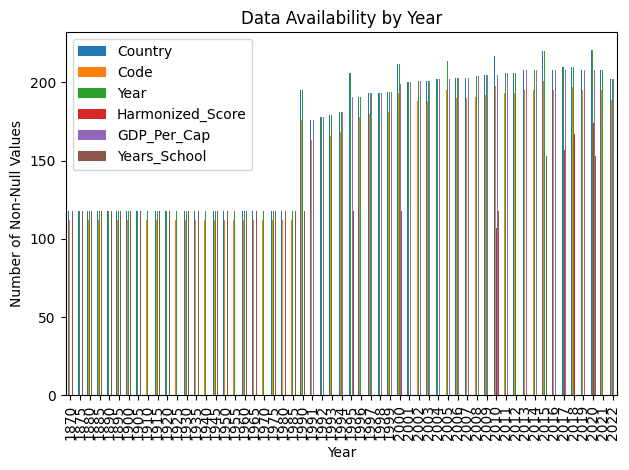

In [43]:
plt.figure(figsize=(20, 10))
year_counts.plot(kind='bar')
plt.title('Data Availability by Year')
plt.xlabel('Year')
plt.ylabel('Number of Non-Null Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [44]:
start_year = 1995
end_year = 2019
df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]

In [45]:
# Calculate GDP per capita growth by year
df['GDP_growth'] = df.groupby('Country')['GDP_Per_Cap'].pct_change()

# Find earliest GDP per capita value
initial_gdp = df.groupby('Country').first()['GDP_Per_Cap']
df = df.merge(initial_gdp.rename('Initial_GDP'), left_on='Country', right_index=True)

# Find earliest schooling years value
initial_schooling = df.groupby('Country').first()['Years_School']
df = df.merge(initial_schooling.rename('Initial_Schooling'), left_on='Country', right_index=True)

# Calculate average test score for each country
avg_test_score = df.groupby('Country')['Harmonized_Score'].mean()
df = df.merge(avg_test_score.rename('Avg_Test_Score'), left_on='Country', right_index=True)

# Calculate average annual growth rate over the entire time period
df['Avg_Annual_Growth'] = (df.groupby('Country')['GDP_Per_Cap'].transform(lambda x: (x.iloc[-1]/x.iloc[0])**(1/len(x)) - 1))

<ipython-input-45-de6d56ad73ce>:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['GDP_growth'] = df.groupby('Country')['GDP_Per_Cap'].pct_change()
<ipython-input-45-de6d56ad73ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GDP_growth'] = df.groupby('Country')['GDP_Per_Cap'].pct_change()


In [46]:
df

,Country,Code,Year,Harmonized_Score,GDP_Per_Cap,Years_School,GDP_growth,Initial_GDP,Initial_Schooling,Avg_Test_Score,Avg_Annual_Growth
25,Afghanistan,AFG,1995,NaN,NaN,2.40,NaN,1280.4631,2.40,354.879400,NaN
26,Afghanistan,AFG,2000,NaN,NaN,3.03,NaN,1280.4631,2.40,354.879400,NaN
27,Afghanistan,AFG,2002,NaN,1280.4631,NaN,NaN,1280.4631,2.40,354.879400,NaN
28,Afghanistan,AFG,2003,NaN,1292.3335,NaN,0.009270,1280.4631,2.40,354.879400,NaN
29,Afghanistan,AFG,2004,NaN,1260.0605,NaN,-0.024973,1280.4631,2.40,354.879400,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9487,Zimbabwe,ZWE,2015,NaN,2313.8787,8.03,-0.001328,2641.3782,6.85,395.445627,-0.007226
9488,Zimbabwe,ZWE,2016,NaN,2286.6235,NaN,-0.011779,2641.3782,6.85,395.445627,-0.007226
9489,Zimbabwe,ZWE,2017,396.00000,2331.7808,NaN,0.019748,2641.3782,6.85,395.445627,-0.007226
9490,Zimbabwe,ZWE,2018,396.13882,2399.6216,NaN,0.029094,2641.3782,6.85,395.445627,-0.007226


In [47]:
# Creating final dataframe for regression
regression_df = df.groupby('Country').first()[['Avg_Annual_Growth', 'Initial_Schooling', 'Avg_Test_Score', 'Initial_GDP']]
regression_df = regression_df.dropna()

print(regression_df.head())
print(f"Number of countries in final dataset: {len(regression_df)}")

           Avg_Annual_Growth  Initial_Schooling  Avg_Test_Score  Initial_GDP
Country                                                                     
Albania             0.045661               8.54      418.518623    4471.6235
Algeria             0.015002               5.76      381.831593    8013.1235
Argentina           0.009782               8.91      419.018013   17303.9240
Armenia             0.065767              10.45      442.984725    2912.7810
Australia           0.016375              11.51      528.198893   32927.3320
Number of countries in final dataset: 130


In [48]:
regression_df

,Avg_Annual_Growth,Initial_Schooling,Avg_Test_Score,Initial_GDP
Country,,,,
Albania,0.045661,8.54,418.518623,4471.6235
Algeria,0.015002,5.76,381.831593,8013.1235
Argentina,0.009782,8.91,419.018013,17303.9240
Armenia,0.065767,10.45,442.984725,2912.7810
Australia,0.016375,11.51,528.198893,32927.3320
...,...,...,...,...
United States,0.015012,12.83,519.545047,43042.2150
Uruguay,0.023757,8.08,443.077800,13095.3930
Vietnam,0.052911,7.99,523.852667,2825.0164


# Regression 1: $y$ = GDP_Per_Capita, $X$ = Composite_Score

#### Note that the original Hanushek model used average annual growth rate in GDP per capita instead of the value of GDP per capita itself as $y$ in their model. I was curious about predicting GDP per capita (and in my case, it appears to yield better results, which will be clearer towards the end).

In [49]:
merged_df = pd.merge(pisa_tim, gdp, on=['Country', 'Code', 'Year'], how='inner')

# Drop any rows with missing values
merged_df = merged_df.dropna()

print(merged_df.head())
print(f"Number of observations: {len(merged_df)}")

       Country Code  Year  PISA_std  TIMSS_std  Composite_Score  GDP_Per_Cap
19   Australia  AUS  2003  1.036050   0.630120         0.833085    40535.668
25   Australia  AUS  2015  0.618014   0.512326         0.565170    47543.082
78      Canada  CAN  2015  0.981130   0.795031         0.888081    47507.453
87       Chile  CHL  2015 -0.617428  -0.555673        -0.586550    24464.746
166    Georgia  GEO  2015 -1.120418  -0.437879        -0.779148    12605.140
Number of observations: 37


In [50]:
X = merged_df['Composite_Score']
y = merged_df['GDP_Per_Cap']

slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

print(f"Correlation coefficient: {r_value}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")

Correlation coefficient: 0.45996406753315017
R-squared: 0.21156694342164034
P-value: 0.004179513112491903


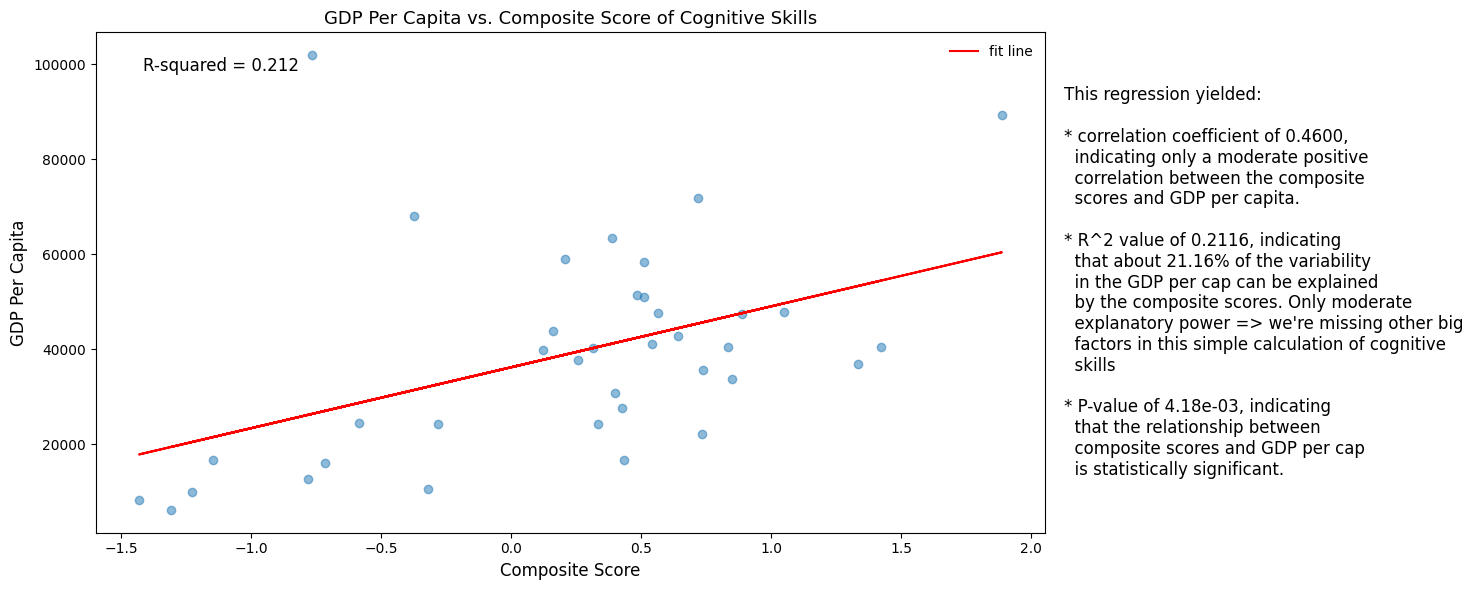

In [51]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(X, y, alpha=0.5)
ax.plot(X, intercept + slope*X, 'r', label='fit line')
ax.set_xlabel('Composite Score', fontsize=12)
ax.set_ylabel('GDP Per Capita', fontsize=12)
ax.set_title('GDP Per Capita vs. Composite Score of Cognitive Skills', fontsize=13)
ax.legend(frameon=False)

ax.text(0.05, 0.95, f'R-squared = {r_value**2:.3f}', transform=ax.transAxes,
        verticalalignment='top', fontsize=12)

annotation_text = (
    "This regression yielded:\n\n"
    f"* correlation coefficient of {r_value:.4f},\n"
    "  indicating only a moderate positive\n"
    "  correlation between the composite\n"
    "  scores and GDP per capita.\n\n"
    f"* R^2 value of {r_value**2:.4f}, indicating\n"
    f"  that about {r_value**2*100:.2f}% of the variability\n"
    "  in the GDP per cap can be explained\n"
    "  by the composite scores. Only moderate\n"
    "  explanatory power => we're missing other big\n"
    "  factors in this simple calculation of cognitive\n"
    "  skills \n\n"
    f"* P-value of {p_value:.2e}, indicating\n"
    "  that the relationship between\n"
    "  composite scores and GDP per cap\n"
    "  is statistically significant."
)

fig.text(1.02, 0.5, annotation_text,
         verticalalignment='center', horizontalalignment='left',
         transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(right=0.7)
plt.show()

# Regression 2: $y$ = GDP_Per_Capita, $X$ = Harmonized_Score

#### So previously, I had calculated the Composite Score from the PISA and TIMSS tests. I later found a 'Harmonized Score' dataset that is essentially a more robust and composite score than the one I had calculated, and wanted to compare the results from the two.

In [52]:
merged_df = pd.merge(harmonized, gdp, on=['Country', 'Code', 'Year'], how='inner')

# Drop any rows with missing values
merged_df = merged_df.dropna()

print(merged_df.head())
print(f"Number of observations: {len(merged_df)}")

       Country Code  Year  Harmonized_Score  GDP_Per_Cap
0  Afghanistan  AFG  2017         355.00000     2096.093
1  Afghanistan  AFG  2018         354.75880     2060.699
2  Afghanistan  AFG  2020         354.75880     1968.341
3      Albania  ALB  2010         397.22687    10749.519
4      Albania  ALB  2017         429.00000    12771.054
Number of observations: 599


In [53]:
X = merged_df['Harmonized_Score']
y = merged_df['GDP_Per_Cap']

slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

print(f"Correlation coefficient: {r_value}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")

Correlation coefficient: 0.7007489897201642
R-squared: 0.4910491465938308
P-value: 1.2888447399875548e-89


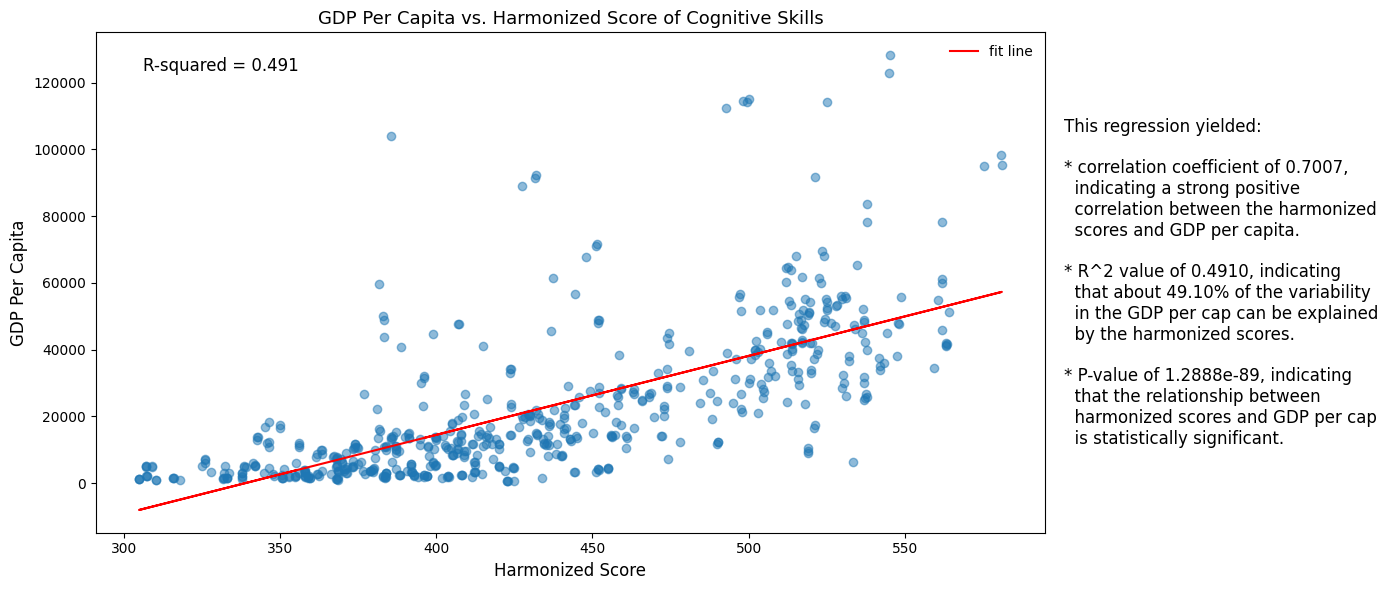

In [54]:
slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(X, y, alpha=0.5)
ax.plot(X, intercept + slope*X, 'r', label='fit line')
ax.set_xlabel('Harmonized Score', fontsize=12)
ax.set_ylabel('GDP Per Capita', fontsize=12)
ax.set_title('GDP Per Capita vs. Harmonized Score of Cognitive Skills', fontsize=13)
ax.legend(frameon=False)

ax.text(0.05, 0.95, f'R-squared = {r_value**2:.3f}', transform=ax.transAxes,
        verticalalignment='top', fontsize=12)

annotation_text = (
    "This regression yielded:\n\n"
    "* correlation coefficient of 0.7007,\n"
    "  indicating a strong positive\n"
    "  correlation between the harmonized\n"
    "  scores and GDP per capita.\n\n"
    "* R^2 value of 0.4910, indicating\n"
    "  that about 49.10% of the variability\n"
    "  in the GDP per cap can be explained\n"
    "  by the harmonized scores.\n\n"
    "* P-value of 1.2888e-89, indicating\n"
    "  that the relationship between\n"
    "  harmonized scores and GDP per cap\n"
    "  is statistically significant."
)

fig.text(1.02, 0.5, annotation_text,
         verticalalignment='center', horizontalalignment='left',
         transform=ax.transAxes, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(right=0.7)
plt.show()

# Regression 3: $y$ = Average Annual Growth Rate
# $X$ = [Average Test Score, Initial Schooling Years, Initial GDP]

In [55]:
X = regression_df[['Initial_Schooling', 'Avg_Test_Score', 'Initial_GDP']]
X = sm.add_constant(X)
y = regression_df['Avg_Annual_Growth']

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Avg_Annual_Growth   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     15.19
Date:                Mon, 04 Nov 2024   Prob (F-statistic):           1.69e-08
Time:                        09:13:15   Log-Likelihood:                 370.62
No. Observations:                 130   AIC:                            -733.2
Df Residuals:                     126   BIC:                            -721.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0120      0.01

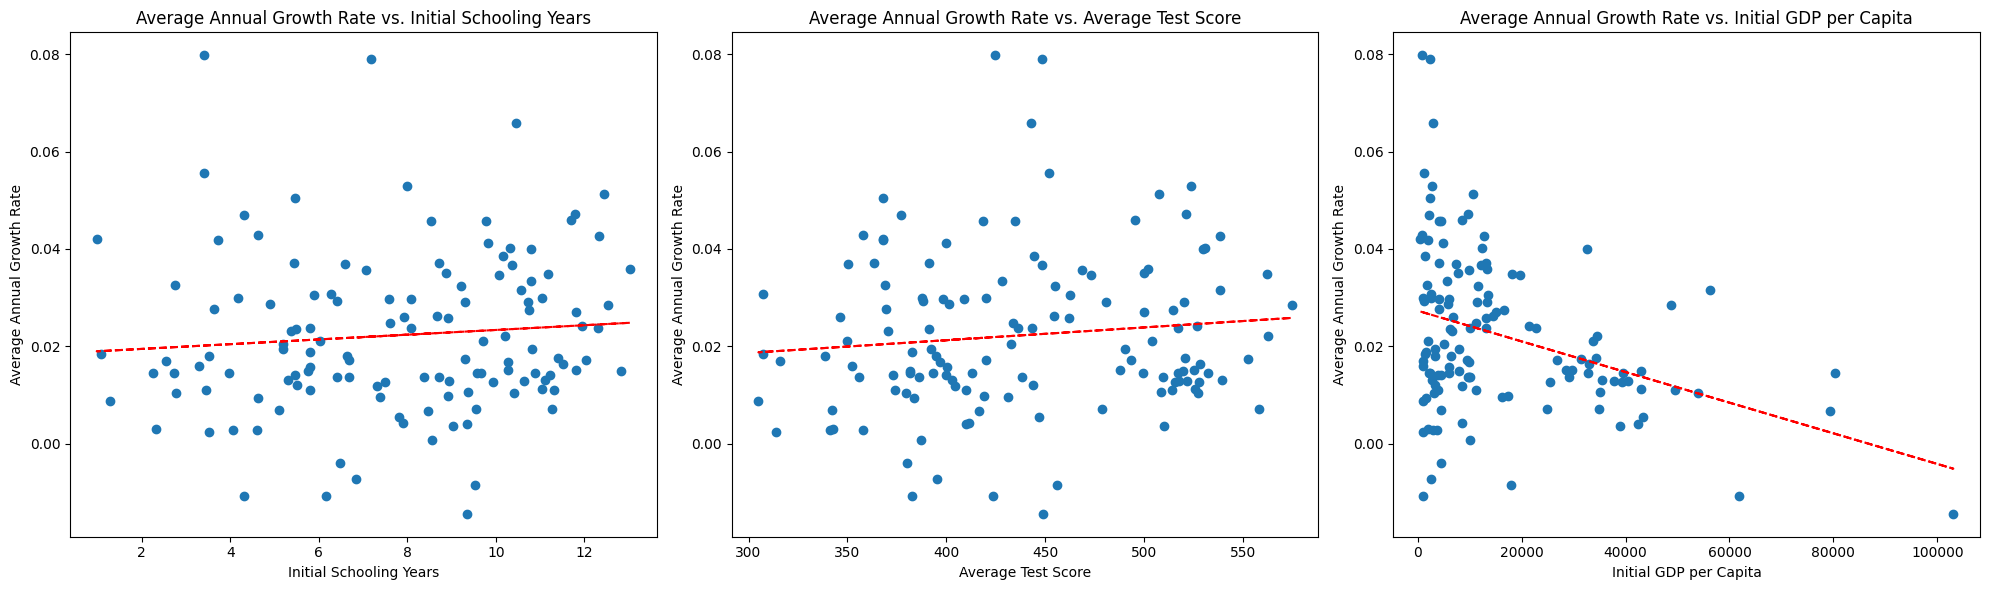

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Initial Schooling vs Growth
axs[0].scatter(regression_df['Initial_Schooling'], regression_df['Avg_Annual_Growth'])
axs[0].set_xlabel('Initial Schooling Years')
axs[0].set_ylabel('Average Annual Growth Rate')
axs[0].set_title('Average Annual Growth Rate vs. Initial Schooling Years')
z = np.polyfit(regression_df['Initial_Schooling'], regression_df['Avg_Annual_Growth'], 1)
p = np.poly1d(z)
axs[0].plot(regression_df['Initial_Schooling'], p(regression_df['Initial_Schooling']), "r--")

# Average Test Score vs Growth
axs[1].scatter(regression_df['Avg_Test_Score'], regression_df['Avg_Annual_Growth'])
axs[1].set_xlabel('Average Test Score')
axs[1].set_ylabel('Average Annual Growth Rate')
axs[1].set_title('Average Annual Growth Rate vs. Average Test Score')
z = np.polyfit(regression_df['Avg_Test_Score'], regression_df['Avg_Annual_Growth'], 1)
p = np.poly1d(z)
axs[1].plot(regression_df['Avg_Test_Score'], p(regression_df['Avg_Test_Score']), "r--")

# Initial GDP vs Growth
axs[2].scatter(regression_df['Initial_GDP'], regression_df['Avg_Annual_Growth'])
axs[2].set_xlabel('Initial GDP per Capita')
axs[2].set_ylabel('Average Annual Growth Rate')
axs[2].set_title('Average Annual Growth Rate vs. Initial GDP per Capita')
z = np.polyfit(regression_df['Initial_GDP'], regression_df['Avg_Annual_Growth'], 1)
p = np.poly1d(z)
axs[2].plot(regression_df['Initial_GDP'], p(regression_df['Initial_GDP']), "r--")

plt.tight_layout()
plt.show()


Comments:

* R-squared = 0.266 i.e. about 26.6% of the variation in average annual econ growth can be explained by the model. This is not super high, but it seems like this might not be all that uncommon in cross-country growth regressions.

* The Avg_Test_Score and Initial_GDP are statistically significant (p < 0.05), while Initial_Schooling is not, which agrees with the general idea presented in Hanushek's work (i.e. that cognitive skills are a better determinant of economic growth than mere schooling years).

* Positive coefficient on Avg_Test_Score (8.718e-05) => higher test scores are associated with higher growth rates, supporting Hanushek's hypothesis.

* Negative coefficient on Initial_GDP (-5.477e-07) => convergence (" poorer economies' per capita incomes will tend to grow at faster rates than richer economies" from [Wikipedia](https://en.wikipedia.org/wiki/Convergence_(economics)))